In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
from tqdm import tqdm
from numpy import linalg as LA
from scipy import spatial
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [19]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [20]:
train_input = train_input + val_input
train_output = train_output + val_output

In [21]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [22]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [23]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [24]:
train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
test_input = torch.from_numpy(test_input)

train_output = torch.from_numpy(train_output)
val_output = torch.from_numpy(val_output)
test_output = torch.from_numpy(test_output)

In [25]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

torch.Size([66175, 13953])
torch.Size([28921, 13953])
torch.Size([1000, 13953])
torch.Size([66175, 1])
torch.Size([28921, 1])
torch.Size([1000, 1])


In [32]:
def top_samples(source, target, num):
    temp_list = []
    for i in range(target.shape[0]):
        temp_list.append([spatial.distance.cosine(source, target[i]), i])
    temp_list.sort()
    return [ele[1] for ele in temp_list[:num]]

In [33]:
input_near_ind_list = []
output_near_ind_list = []

for i in tqdm(range(test_input.shape[0])):
    near_neig_ind = top_samples(test_input[i], train_input, 20)
    input_near_ind_list.append(train_input[near_neig_ind])
    output_near_ind_list.append(train_output[near_neig_ind])
    
input_near = np.concatenate(input_near_ind_list, axis= 0)
output_near = np.concatenate(output_near_ind_list, axis= 0)

100%|██████████| 1000/1000 [2:16:44<00:00,  8.20s/it] 


In [34]:
# with open(r"input_near_cos.pickle", "wb") as output_file:
#     pickle.dump(input_near, output_file)
    
# with open(r"output_near_cos.pickle", "wb") as output_file:
#     pickle.dump(output_near, output_file)

In [35]:
# with open(r"input_near_cos.pickle", "rb") as input_file:
#     input_near = pickle.load(input_file)
    
# with open(r"output_near_cos.pickle", "rb") as input_file:
#     output_near = pickle.load(input_file)

In [36]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [37]:
train_input = train_input.float()
val_input = val_input.float()
test_input = test_input.float()

train_output = train_output.float()
val_output = val_output.float()
test_output = test_output.float()

In [38]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [39]:
train_input = train_input.to(device)
val_input = val_input.to(device)
test_input = test_input.to(device)

train_output = train_output.to(device)
val_output = val_output.to(device)
test_output = test_output.to(device)

In [40]:
input_near = torch.from_numpy(input_near)
output_near = torch.from_numpy(output_near)

In [41]:
input_near = input_near.to(device)
output_near = output_near.to(device)

In [42]:
input_feature = RNA_s1d1.shape[1]

In [43]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [44]:
PATH = 'No_norm_model_RNA_pro'

In [47]:
def fit(num_epochs, model, loss_fn, RNA, pro):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            near_pred = model(input_near)
            near_loss = loss_fn(near_pred, output_near)
            near_loss = torch.sqrt(near_loss)
            near_loss = near_loss.cpu().detach().numpy()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            print('Epoch ', epoch, 'near loss:', near_loss, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 13, figsize = (33, 3))
            for i in range(1):
                
                ax[0].scatter(output_near.cpu().detach().numpy()[:, 0], near_pred.cpu().detach().numpy()[:, 0], c='purple', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Nearest neighbor result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')
                
                ax[1].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d1 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d2 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')

                ax[3].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s1d3 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')
                
                ax[4].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d1 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d4 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')

                ax[6].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s2d5 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')
                
                ax[7].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d1 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d6 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')

                ax[9].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s3d7 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')
                
                ax[10].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d1 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d8 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')

                ax[12].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[12].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[12].set_title('s4d9 result')
                ax[12].set_xlabel('true')
                ax[12].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 near loss: 1.9583267 s1d1:  1.9416007 s1d2:  2.1054194 s1d3:  1.8431406 s2d1: 0.7302188 s2d4: 1.3748949 s2d5: 1.3040115 s3d1: 0.5356997 s3d6: 1.3528571 s3d7: 1.5052285 s4d1: 1.7326784 s4d8: 2.0650487 s4d9: 1.204837


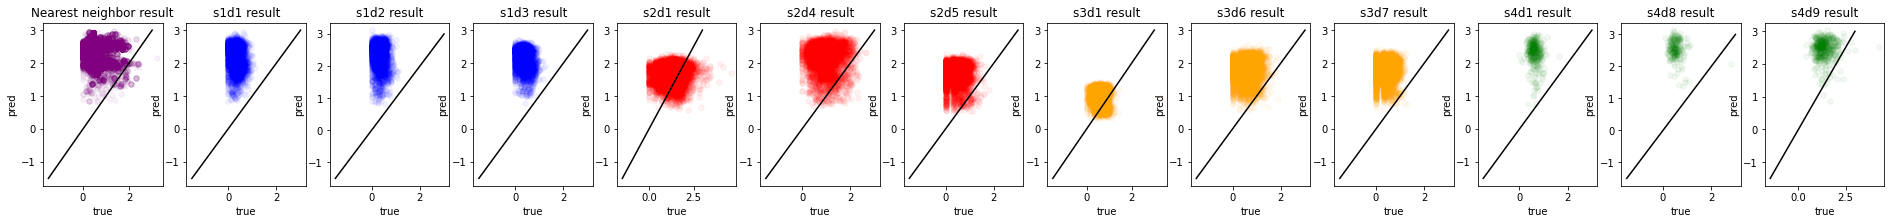

Epoch  100 near loss: 0.19500907 s1d1:  0.2232035 s1d2:  0.18646619 s1d3:  0.21010068 s2d1: 0.7875485 s2d4: 0.6057635 s2d5: 0.31448695 s3d1: 0.22603822 s3d6: 0.341145 s3d7: 0.28338522 s4d1: 0.25205967 s4d8: 0.26793703 s4d9: 0.9394208
Epoch  200 near loss: 0.11014196 s1d1:  0.2275371 s1d2:  0.18827534 s1d3:  0.2120688 s2d1: 0.71533364 s2d4: 0.56431895 s2d5: 0.3272001 s3d1: 0.2937489 s3d6: 0.36301577 s3d7: 0.298714 s4d1: 0.26396063 s4d8: 0.28581738 s4d9: 0.93936586
Epoch  300 near loss: 0.08740302 s1d1:  0.2486108 s1d2:  0.20157936 s1d3:  0.2263078 s2d1: 0.6829152 s2d4: 0.5367488 s2d5: 0.34673047 s3d1: 0.31221616 s3d6: 0.3724916 s3d7: 0.31346852 s4d1: 0.24711044 s4d8: 0.2752861 s4d9: 0.90289927
Epoch  400 near loss: 0.064558774 s1d1:  0.22580715 s1d2:  0.18935941 s1d3:  0.21116765 s2d1: 0.7163161 s2d4: 0.558972 s2d5: 0.32996225 s3d1: 0.30132926 s3d6: 0.36411372 s3d7: 0.29799533 s4d1: 0.26693755 s4d8: 0.29175907 s4d9: 0.96168476
Epoch  500 near loss: 0.052574616 s1d1:  0.22677736 s1d2:  0

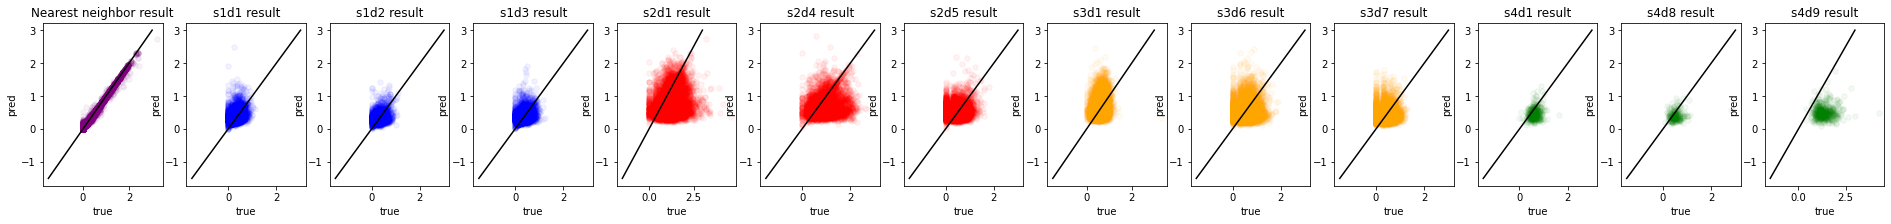

Epoch  1100 near loss: 0.02496785 s1d1:  0.23750417 s1d2:  0.19501252 s1d3:  0.21997991 s2d1: 0.7112099 s2d4: 0.55151826 s2d5: 0.34619886 s3d1: 0.30919373 s3d6: 0.37183228 s3d7: 0.30845347 s4d1: 0.26366588 s4d8: 0.29012895 s4d9: 0.94852304
Epoch  1200 near loss: 0.02245473 s1d1:  0.23668915 s1d2:  0.19500734 s1d3:  0.21950565 s2d1: 0.71297777 s2d4: 0.5523044 s2d5: 0.3467535 s3d1: 0.30778056 s3d6: 0.37148532 s3d7: 0.30863327 s4d1: 0.2652828 s4d8: 0.29181045 s4d9: 0.95109963
Epoch  1300 near loss: 0.028023455 s1d1:  0.2305477 s1d2:  0.19184555 s1d3:  0.2155592 s2d1: 0.7220925 s2d4: 0.55976295 s2d5: 0.3413638 s3d1: 0.30497313 s3d6: 0.36990628 s3d7: 0.3042172 s4d1: 0.27126396 s4d8: 0.29551676 s4d9: 0.96636814
Epoch  1400 near loss: 0.046576265 s1d1:  0.2553435 s1d2:  0.20553972 s1d3:  0.23313142 s2d1: 0.68760365 s2d4: 0.5377344 s2d5: 0.36787257 s3d1: 0.32080594 s3d6: 0.380866 s3d7: 0.32485685 s4d1: 0.2562146 s4d8: 0.2850451 s4d9: 0.9100259
Epoch  1500 near loss: 0.047770035 s1d1:  0.222656

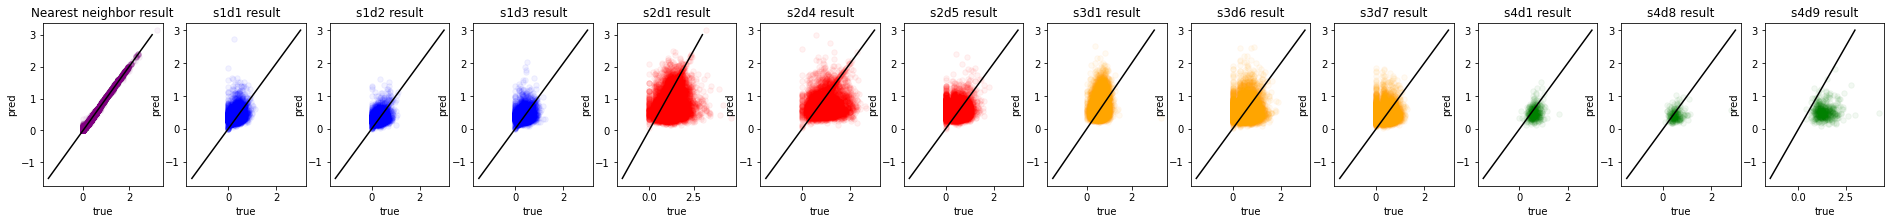

Epoch  2100 near loss: 0.01340213 s1d1:  0.23921616 s1d2:  0.1962216 s1d3:  0.2219779 s2d1: 0.70785564 s2d4: 0.55270207 s2d5: 0.35502854 s3d1: 0.31555074 s3d6: 0.37608826 s3d7: 0.31432068 s4d1: 0.2693027 s4d8: 0.29426965 s4d9: 0.95175916
Epoch  2200 near loss: 0.022186162 s1d1:  0.2455763 s1d2:  0.19983567 s1d3:  0.22656548 s2d1: 0.698277 s2d4: 0.54629487 s2d5: 0.36314744 s3d1: 0.32014728 s3d6: 0.37889728 s3d7: 0.3199684 s4d1: 0.26500067 s4d8: 0.29136708 s4d9: 0.93563914
Epoch  2300 near loss: 0.013902869 s1d1:  0.23548488 s1d2:  0.19460575 s1d3:  0.21951424 s2d1: 0.71346354 s2d4: 0.55628717 s2d5: 0.35214353 s3d1: 0.31296676 s3d6: 0.37444165 s3d7: 0.31149948 s4d1: 0.27178478 s4d8: 0.29607505 s4d9: 0.9594027
Epoch  2400 near loss: 0.015361217 s1d1:  0.23476636 s1d2:  0.19427559 s1d3:  0.219062 s2d1: 0.7141337 s2d4: 0.55728006 s2d5: 0.35172555 s3d1: 0.3135169 s3d6: 0.3746251 s3d7: 0.31134802 s4d1: 0.2736933 s4d8: 0.2975406 s4d9: 0.9627665
Epoch  2500 near loss: 0.01363434 s1d1:  0.242392

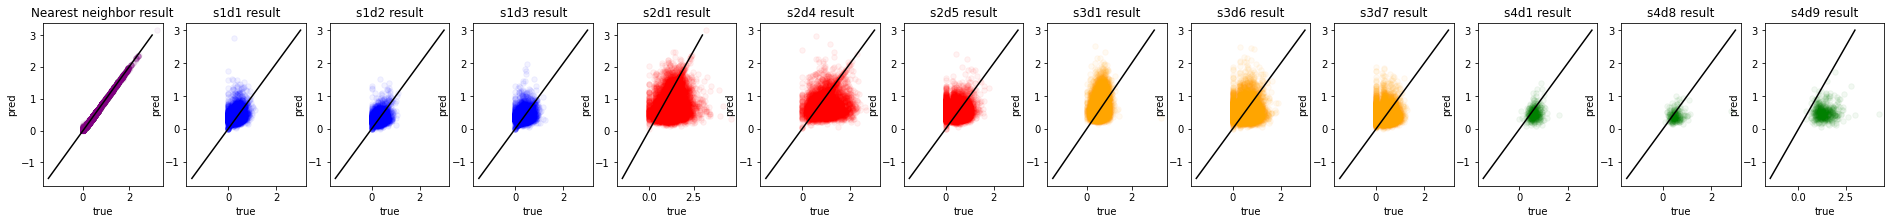

Epoch  3100 near loss: 0.012691953 s1d1:  0.23613578 s1d2:  0.1947234 s1d3:  0.22046275 s2d1: 0.71308726 s2d4: 0.55779374 s2d5: 0.3536435 s3d1: 0.31775793 s3d6: 0.37674177 s3d7: 0.31353983 s4d1: 0.27528012 s4d8: 0.29849952 s4d9: 0.96374804
Epoch  3200 near loss: 0.009208876 s1d1:  0.2384716 s1d2:  0.19597432 s1d3:  0.22199576 s2d1: 0.7088074 s2d4: 0.5547576 s2d5: 0.3567467 s3d1: 0.31956565 s3d6: 0.37733677 s3d7: 0.31538486 s4d1: 0.27290767 s4d8: 0.2964044 s4d9: 0.95639735
Epoch  3300 near loss: 0.011879732 s1d1:  0.23659867 s1d2:  0.1949842 s1d3:  0.22082713 s2d1: 0.7126011 s2d4: 0.55676574 s2d5: 0.35441947 s3d1: 0.31775436 s3d6: 0.37648645 s3d7: 0.3138517 s4d1: 0.2744387 s4d8: 0.29734305 s4d9: 0.9609017
Epoch  3400 near loss: 0.011059596 s1d1:  0.23689964 s1d2:  0.19518879 s1d3:  0.22101462 s2d1: 0.71123534 s2d4: 0.55656236 s2d5: 0.355224 s3d1: 0.31820235 s3d6: 0.37674135 s3d7: 0.31440163 s4d1: 0.27452284 s4d8: 0.2973693 s4d9: 0.96022946
Epoch  3500 near loss: 0.02289428 s1d1:  0.2322

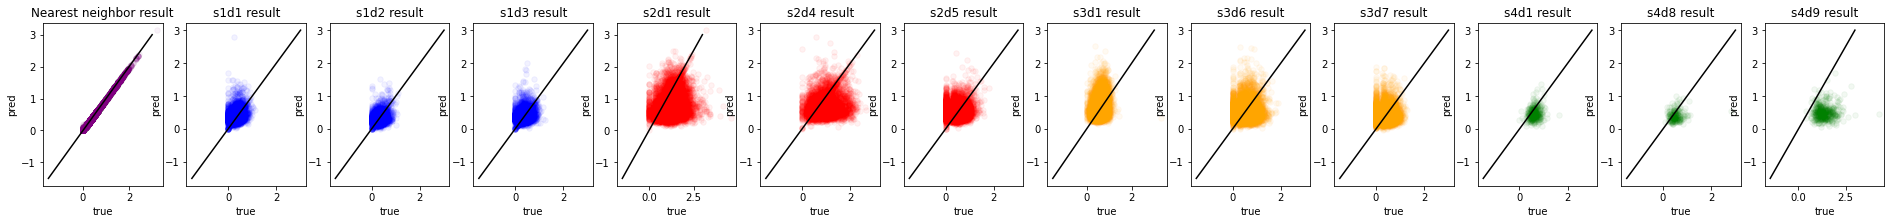

Epoch  4100 near loss: 0.007105509 s1d1:  0.23931797 s1d2:  0.1963013 s1d3:  0.22296733 s2d1: 0.70656174 s2d4: 0.5543016 s2d5: 0.35936075 s3d1: 0.32219464 s3d6: 0.37852073 s3d7: 0.31744683 s4d1: 0.2739836 s4d8: 0.29669946 s4d9: 0.95574576
Epoch  4200 near loss: 0.007683218 s1d1:  0.23889096 s1d2:  0.19613814 s1d3:  0.22272277 s2d1: 0.70757747 s2d4: 0.55495155 s2d5: 0.35842884 s3d1: 0.32161492 s3d6: 0.37822255 s3d7: 0.31682903 s4d1: 0.2742997 s4d8: 0.2968433 s4d9: 0.9568348
Epoch  4300 near loss: 0.007789784 s1d1:  0.23809768 s1d2:  0.19572593 s1d3:  0.22218643 s2d1: 0.7081052 s2d4: 0.55526245 s2d5: 0.3583556 s3d1: 0.3211804 s3d6: 0.3778662 s3d7: 0.31626725 s4d1: 0.27461034 s4d8: 0.29689315 s4d9: 0.95722705
Epoch  4400 near loss: 0.007370733 s1d1:  0.23986462 s1d2:  0.19653058 s1d3:  0.22334848 s2d1: 0.7061903 s2d4: 0.5540463 s2d5: 0.3598861 s3d1: 0.32274237 s3d6: 0.3787251 s3d7: 0.31785226 s4d1: 0.27394122 s4d8: 0.29632375 s4d9: 0.9548493
Epoch  4500 near loss: 0.006840689 s1d1:  0.239

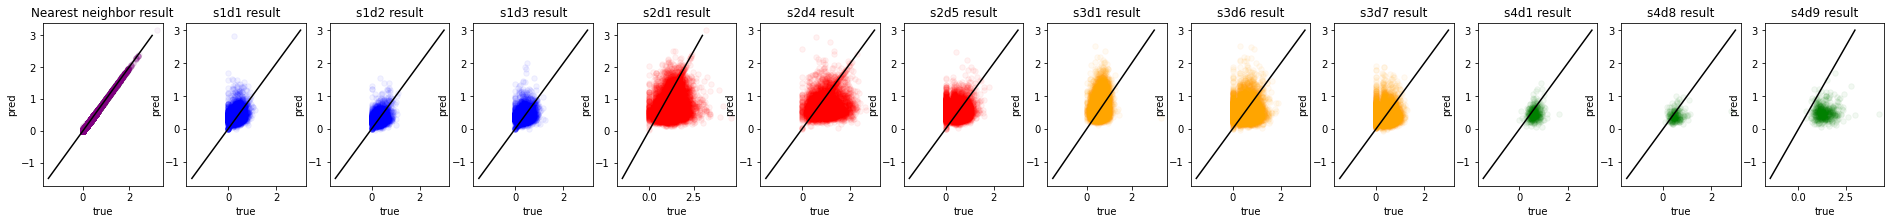

Epoch  5100 near loss: 0.017864045 s1d1:  0.23458034 s1d2:  0.19386047 s1d3:  0.21984929 s2d1: 0.7151574 s2d4: 0.5601248 s2d5: 0.35386652 s3d1: 0.3193816 s3d6: 0.37682754 s3d7: 0.31365463 s4d1: 0.27890012 s4d8: 0.299076 s4d9: 0.9681194
Epoch  5200 near loss: 0.0077372673 s1d1:  0.2402236 s1d2:  0.19646572 s1d3:  0.22398528 s2d1: 0.70650023 s2d4: 0.55476457 s2d5: 0.35983703 s3d1: 0.3241065 s3d6: 0.37931144 s3d7: 0.31814146 s4d1: 0.27526614 s4d8: 0.29632288 s4d9: 0.9564069
Epoch  5300 near loss: 0.015305652 s1d1:  0.23646572 s1d2:  0.19478011 s1d3:  0.22113255 s2d1: 0.7118772 s2d4: 0.5580228 s2d5: 0.35599208 s3d1: 0.32106644 s3d6: 0.37756515 s3d7: 0.31537604 s4d1: 0.27792168 s4d8: 0.29818603 s4d9: 0.96446425
Epoch  5400 near loss: 0.01818797 s1d1:  0.23406743 s1d2:  0.1937643 s1d3:  0.21947941 s2d1: 0.7148475 s2d4: 0.5597894 s2d5: 0.35444617 s3d1: 0.3189674 s3d6: 0.37651315 s3d7: 0.31384617 s4d1: 0.27905548 s4d8: 0.2989259 s4d9: 0.96742857
Epoch  5500 near loss: 0.0058720587 s1d1:  0.241

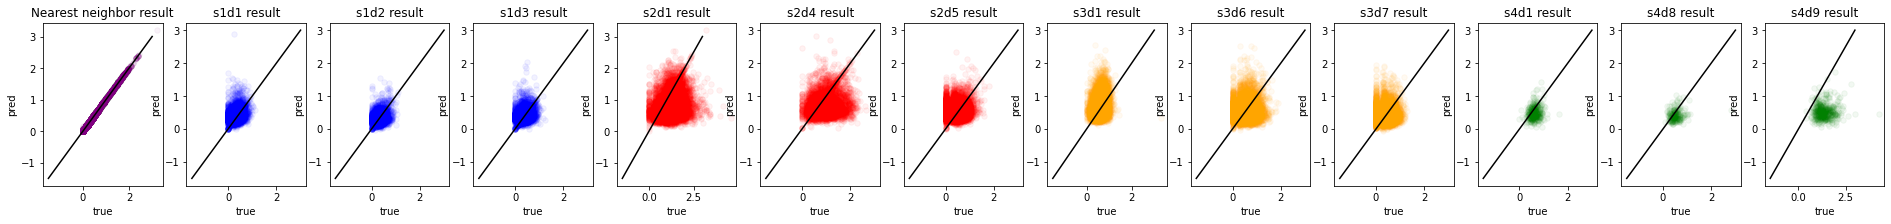

Epoch  6100 near loss: 0.007722874 s1d1:  0.2396874 s1d2:  0.19632125 s1d3:  0.22347634 s2d1: 0.7067409 s2d4: 0.5549631 s2d5: 0.3600374 s3d1: 0.32389915 s3d6: 0.37886366 s3d7: 0.3181312 s4d1: 0.27586842 s4d8: 0.29637295 s4d9: 0.9568166
Epoch  6200 near loss: 0.00731757 s1d1:  0.24354815 s1d2:  0.19825415 s1d3:  0.22630551 s2d1: 0.69977283 s2d4: 0.55101144 s2d5: 0.36547202 s3d1: 0.32720926 s3d6: 0.38053867 s3d7: 0.32156995 s4d1: 0.2730741 s4d8: 0.29433715 s4d9: 0.9472683
Epoch  6300 near loss: 0.0055947965 s1d1:  0.24147263 s1d2:  0.19710419 s1d3:  0.22505635 s2d1: 0.70382315 s2d4: 0.5536063 s2d5: 0.36246264 s3d1: 0.32645044 s3d6: 0.38019538 s3d7: 0.31967428 s4d1: 0.27530253 s4d8: 0.29553834 s4d9: 0.95313674
Epoch  6400 near loss: 0.0055374587 s1d1:  0.24246436 s1d2:  0.19759625 s1d3:  0.22566706 s2d1: 0.70201033 s2d4: 0.5525748 s2d5: 0.3636145 s3d1: 0.32685214 s3d6: 0.3803401 s3d7: 0.32050025 s4d1: 0.27457538 s4d8: 0.29511356 s4d9: 0.9509565
Epoch  6500 near loss: 0.0052400236 s1d1:  0

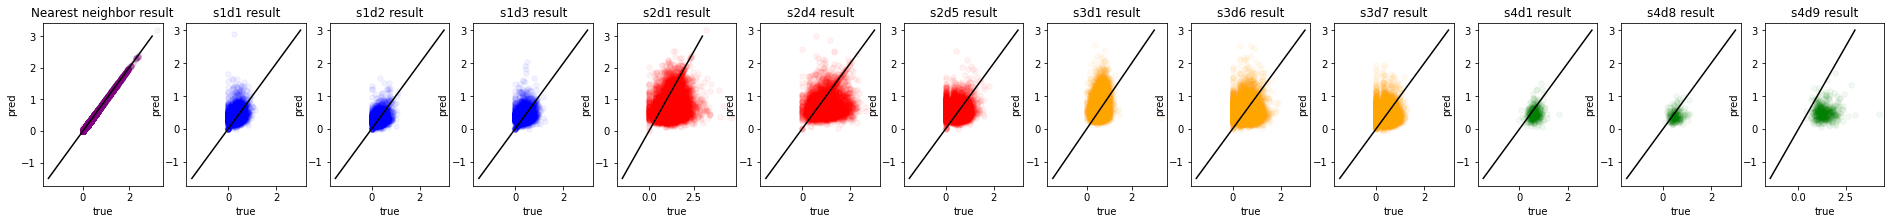

Epoch  7100 near loss: 0.019792616 s1d1:  0.24961372 s1d2:  0.20118853 s1d3:  0.23115808 s2d1: 0.6918157 s2d4: 0.5464496 s2d5: 0.3723641 s3d1: 0.33319917 s3d6: 0.38406336 s3d7: 0.3264207 s4d1: 0.2707838 s4d8: 0.29152104 s4d9: 0.9340144
Epoch  7200 near loss: 0.010861878 s1d1:  0.24540204 s1d2:  0.1990997 s1d3:  0.22794694 s2d1: 0.69649273 s2d4: 0.5492724 s2d5: 0.3685964 s3d1: 0.32942203 s3d6: 0.3818823 s3d7: 0.32330903 s4d1: 0.27288818 s4d8: 0.293499 s4d9: 0.94243056
Epoch  7300 near loss: 0.0050999313 s1d1:  0.24264868 s1d2:  0.19765867 s1d3:  0.22578669 s2d1: 0.7013502 s2d4: 0.5521193 s2d5: 0.36434987 s3d1: 0.327276 s3d6: 0.38041338 s3d7: 0.3209483 s4d1: 0.27470386 s4d8: 0.29459658 s4d9: 0.950324
Epoch  7400 near loss: 0.0062413127 s1d1:  0.24358945 s1d2:  0.19790806 s1d3:  0.22660333 s2d1: 0.70029515 s2d4: 0.5517851 s2d5: 0.36544675 s3d1: 0.32904264 s3d6: 0.3814176 s3d7: 0.32161573 s4d1: 0.27474937 s4d8: 0.2947445 s4d9: 0.948955
Epoch  7500 near loss: 0.0106424615 s1d1:  0.24489112 

KeyboardInterrupt: 

In [48]:
num_epochs = 50000
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, input_near, output_near)